# Ledouble Loïc (SNS) - Tall Abdoulaye (SNS) - Richard Ilona (CSM)

### Chargement des packages

In [2]:
# !pip install -r requirements.txt

In [1]:
# Pour traitement des données
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdata

# Pour réseaux de neurones
from tensorflow import keras
from tensorflow.keras import layers

# Pour modèles de machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve,make_scorer,f1_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Fonctions utilisées pour le préprocessing des données
from preprocessing import *

# Fonctions utilisées pour l'entraînement des modèles
from fonctions_utiles import *

### Contexte

Des études récentes montrent que les maladies inflammatoires de l'intestin (MII) s'accompagnent de perturbations du microbiote intestinal. Le séquençage ARN du microbiote permet d'identifier et de comparer les différentes bactéries présentes dans l'intestin.

Dans ce projet, nous analyserons les données OTU issues du séquençage, ainsi qu'une partie des métadonnées des patients, pour entraîner plusieurs modèles de machine learning capables de prédire si un individu est sain ou atteint d'une MII. 

### Description des données

Les données disponibles sont organisés en trois tableaux : les métadonnées des patients la table des OTU issues du séquençage et la taxonomie.

In [2]:
data_path = "data.Rdata" 
converted_data = rdata.read_rds(data_path)
data_df = pd.DataFrame(converted_data['meta.full'])
print(f"Dim data_df : {data_df.shape}")

otu_path = "otu.Rdata"
converted_otu = rdata.read_rds(otu_path)
otu_df = pd.DataFrame(converted_otu['otu.full'])
print(f"Dim otu_df : {otu_df.shape}")

tax_path = "taxonomy.Rdata"
converted_tax = rdata.read_rds(tax_path) 
tax_df = pd.DataFrame(converted_tax['taxonomy'])
print(f"Tax_df ---> {tax_df.shape}")


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


Dim data_df : (284, 61)
Dim otu_df : (284, 2565)


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028
C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\rdata\parser\_parser.py:1239: UserWarning: Wrong extension .rds for file in RDATA format
  warnings.warn(  # noqa: B028


Tax_df ---> (9965, 7)


`Métadonnées`: Parmi les nombreuses variables présentes dans les métadonnées (âge, sexe, traitement, localisation, type d'échantillon, etc.), seules deux seront conservées pour cette étude : l'âge et le diagnostic. Les autres variables ont été considérées comme non pertinentes pour l'objectif de prédiction et seront retirées.


La variable `diagnosis` contient différents labels : `no`, `CD`, `UC` et `IC`. La figure suivante montre que la répartition des individus est déséquilibrée.

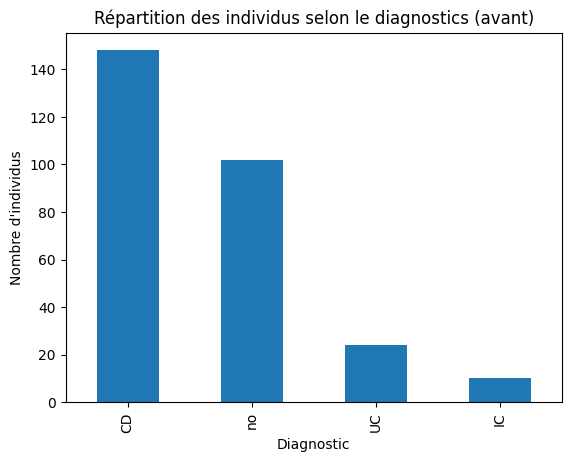

In [3]:
data_df["diagnosis"].value_counts().plot(kind="bar")
plt.ylabel("Nombre d'individus")
plt.xlabel("Diagnostic")
plt.title("Répartition des individus selon le diagnostics (avant)")
plt.show()

En raison des différences d'effectifs dans les catégories, nous allons par la suite regrouper les individus en deux catégories : `healthy` et `disease`.

`OTU`: Dans ce tableau, chaque ligne correspond à un individu et chaque colonne à une bactérie du microbiote. Les valeurs présentes dans le tableau représentent le nombre de séquences observées pour chaque bactérie chez chaque individu. 

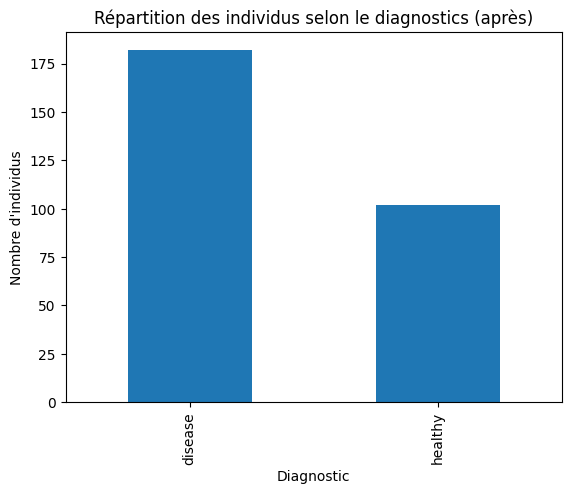

In [4]:
data_df["diagnosis"].apply(lambda s : "healthy" if s =="no" else "disease").value_counts().plot(kind="bar")
plt.ylabel("Nombre d'individus")
plt.xlabel("Diagnostic")
plt.title("Répartition des individus selon le diagnostics (après)")
plt.show()

### Modèles utilisées
 - Modèles simples
    - Regression Logistique
 - Modèles complexes
    - Random Forest
    - XGBoost
    - Réseaux de neurones

L'implémentation des codes se situent dans le fichier `fonctions_utiles.py`.

### Préprocessing

Le pré-processing s'est fait en trois étapes : 

- data_df
  - Mise en place de `sample_name` comme index de notre dataframe.
  - Récupération des colonnes `age` et `diagnosis`.
  - Transformation de la colonne `diagnosis` en miniscules.
  - Suppression des lignes avec au moins un NaN.

- otu_df
  - Suppression des échantillons faibles en profondeur (profondeur >= `12000`).
  - Récupération des OTU avec une prévalence >= `5%` et une somme totale >= `50`.
  - Transformation CLR pour normaliser les données (par ligne): +1 (pour éviter les 0) -> fermeture (proportions) -> log -> centrage (moyenne des logs soustraite).
  - Filtre post-CLR: retrait des `5%` d'OTUs a plus faible variance.
  - Faire test de student et garder les variables les plus pertinentes avec une pvalue de moins de 20%.

- Fusion
  - Jointure interne sur l'index des echantillons (`sample_name`): `merged = data_df.join(otu_df_clr, how='inner')`. On obtient donc `merged_df`.

Les fonctions utilisées pour le preprocessing se situent dans le fichier `preprocessing.py`

Chargement et preprocessing des données.

In [5]:
# Preprocessing et fusion des df
merged_df = mergin(data_df,otu_df,tax_df)

# Transformation de la variable à prédire.
# merged_df["diagnosis"] = merged_df["diagnosis"].apply(lambda s : "healthy" if s =="no" else "disease")

In [9]:
merged_df

,4454356,4455330,2506486,4343580,4465907,4454531,176062,3439275,4414822,187248,...,4371866,569244,4429335,4330715,365385,192963,296945,4431803,4475642,4480061
taxonomy4,Neisseriales,Burkholderiales,Clostridiales,Bacteroidales,Clostridiales,Enterobacteriales,Clostridiales,Clostridiales,Clostridiales,Clostridiales,...,Burkholderiales,RF39,Clostridiales,Clostridiales,Bifidobacteriales,Verrucomicrobiales,Burkholderiales,Streptophyta,Bacteroidales,Rhodobacterales
1939.SKBTI.1068,-0.666988,-0.666988,1.412453,-0.666988,6.025096,1.897961,-0.666988,0.026159,0.026159,-0.666988,...,-0.666988,-0.666988,-0.666988,0.719306,-0.666988,-0.666988,-0.666988,-0.666988,0.94245,-0.666988
1939.SKBTI.0448,-0.549687,0.14346,-0.549687,-0.549687,3.684419,-0.549687,-0.549687,-0.549687,0.14346,0.14346,...,1.529754,-0.549687,-0.549687,0.14346,-0.549687,1.529754,-0.549687,-0.549687,2.394751,-0.549687
1939.SKBTI.0766,-0.442973,-0.442973,1.348787,0.250175,0.65564,1.754252,-0.442973,-0.442973,2.196085,-0.442973,...,-0.442973,-0.442973,0.250175,-0.442973,-0.442973,-0.442973,-0.442973,-0.442973,1.166465,-0.442973
1939.SKBTI.0877,2.837939,-0.340115,-0.340115,-0.340115,1.269323,3.59171,-0.340115,-0.340115,-0.340115,-0.340115,...,-0.340115,-0.340115,1.046179,-0.340115,-0.340115,-0.340115,-0.340115,0.758497,-0.340115,1.046179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939.SKBTI.1353,-0.851664,-0.851664,-0.851664,-0.851664,6.246712,-0.851664,-0.851664,-0.851664,3.080162,0.246948,...,-0.851664,-0.851664,0.246948,-0.851664,-0.851664,-0.851664,-0.851664,0.53463,-0.851664,-0.851664
1939.SKBTI.0759,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,1.374625,-0.234813,-0.234813,-0.234813,-0.234813,...,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813,-0.234813
1939.SKBTI.1033,-0.394998,-0.394998,-0.394998,-0.394998,-0.394998,2.972298,-0.394998,-0.394998,2.169951,-0.394998,...,-0.394998,-0.394998,-0.394998,1.907587,0.298149,-0.394998,-0.394998,-0.394998,-0.394998,-0.394998
1939.SKBTI.1268,-0.362871,-0.362871,-0.362871,-0.362871,-0.362871,2.581568,-0.362871,-0.362871,-0.362871,-0.362871,...,-0.362871,-0.362871,-0.362871,-0.362871,-0.362871,-0.362871,-0.362871,1.583039,1.023424,-0.362871


In [ ]:
merged_df["ag"]

Index(['4454356', '4455330', '2506486', '4343580', '4465907', '4454531',
       '176062', '3439275', '4414822', '187248',
       ...
       '4371866', '569244', '4429335', '4330715', '365385', '192963', '296945',
       '4431803', '4475642', '4480061'],
      dtype='object', length=1049)

### Résultats

Pour présenter les résultats des modèles, on s'est focalisé sur les métriques suivantes : 

- L'`accuracy` : Elle représente la proportion de prédictions correctes.
    - Formule : $\frac{TP + TN}{TP + TN + FP + FN}$

- La `précision` : Elle représente la proportion de vrais positifs parmi toutes les prédictions positives.
    - Formule : $\frac{TP}{TP+FP}$

- Le `rappel` : Elle représente la proportion de vrais positifs parmi ceux qui sont réelement positifs.
    - Formule : $\frac{TP}{TP+FN}$

- Le `f1-score` : Elle représente une moyenne harmonique entre le rappel et la précision.
    - Formule : $2 \cdot \frac{precision \cdot rappel}{precision + rappel}$

- L'`auc` : Elle représente l'aire en dessous de la courbe roc.

- Le `threshold` : Il représente le seuil optimal trouvé sur la courbe roc.

- Le `fold_scores` : Il représente l'ensemble des scores du modèle sur chaque fold.

Dans le contexte de notre classification, avoir un faux négatif est plus impactant qu'avoir un faux positif car se serait ne pas detecté une personne souffrante et donc la métrique à préconiser ici serait plus le $rappel$ que la $précision$ même si cette dernière est à garder sous les radars.


In [7]:
# Création d'un nouveau dataframe pour récupérer les résultats de chaque modèle
report_df = pd.DataFrame(columns=["modèle", "accuracy","precision","recall","f1-score","auc","threshold","fold_scores"])

# Iniatilisation de la liste de matrice de confusion (Chaque élément de la liste va contenir la matrice de confusion d'un modèle)
model_cm = [] 

# Mise en place du X (représentant les variables explicatives) et du Y (représentant la variable à expliquer)
X = merged_df.drop(columns=['diagnosis'])
y = merged_df.loc[:, "diagnosis"].astype(str)

KeyError: "['diagnosis'] not found in axis"

> Réseaux de neurones
***

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5753 - auc: 0.6029 - loss: 0.7185 - val_accuracy: 0.7297 - val_auc: 0.8587 - val_loss: 0.5121 - learning_rate: 0.0030
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7877 - auc: 0.8544 - loss: 0.4845 - val_accuracy: 0.7568 - val_auc: 0.8665 - val_loss: 0.5017 - learning_rate: 0.0030
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7534 - auc: 0.8884 - loss: 0.4438 - val_accuracy: 0.7568 - val_auc: 0.9068 - val_loss: 0.4784 - learning_rate: 0.0030
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9178 - auc: 0.9600 - loss: 0.3044 - val_accuracy: 0.8108 - val_auc: 0.9161 - val_loss: 0.5017 - learning_rate: 0.0030
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9589 - auc: 0.9889 - loss: 0.2073 - val_accuracy: 0.8378 - val_auc: 0.9193 - val_loss: 0.5007 - learning_rate: 0.0030
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9315 - auc: 0.

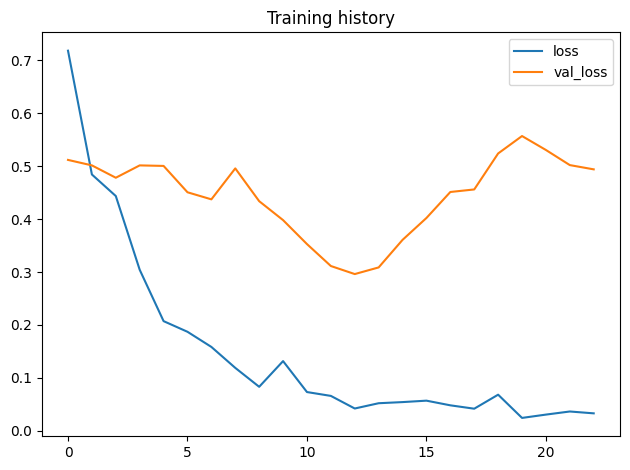

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Report NN (uncalibrated):
               precision    recall  f1-score   support

     disease       0.82      0.82      0.82        50
     healthy       0.69      0.69      0.69        29

    accuracy                           0.77        79
   macro avg       0.75      0.75      0.75        79
weighted avg       0.77      0.77      0.77        79



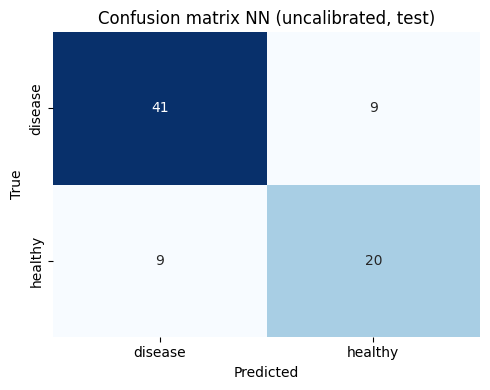

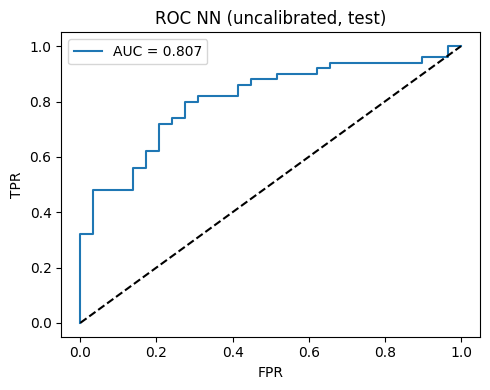

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


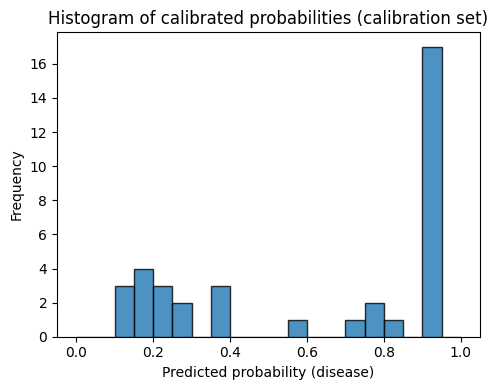

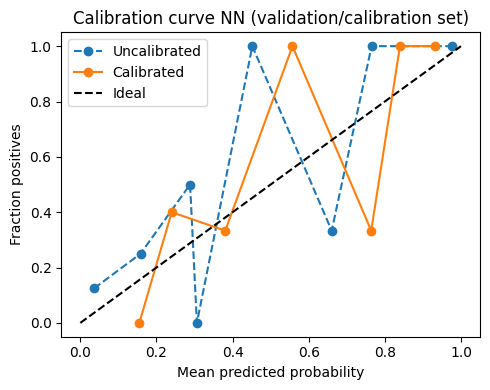

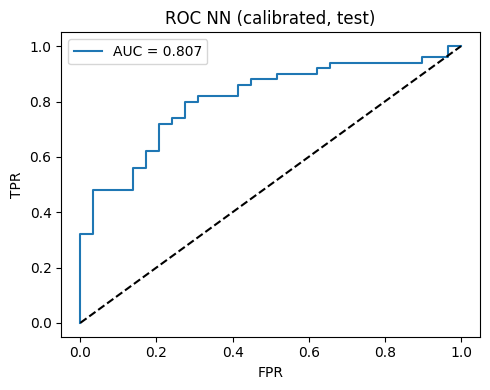

Report NN (calibrated, 0.5):
               precision    recall  f1-score   support

     disease       0.80      0.82      0.81        50
     healthy       0.68      0.66      0.67        29

    accuracy                           0.76        79
   macro avg       0.74      0.74      0.74        79
weighted avg       0.76      0.76      0.76        79



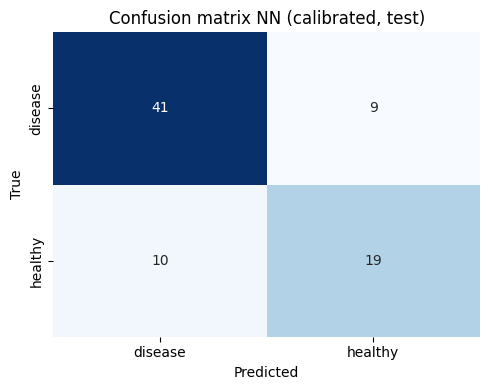

Best threshold (Youden J) NN on calib: 0.7862 | J=0.8261 | TPR=0.8261 | FPR=0.0000


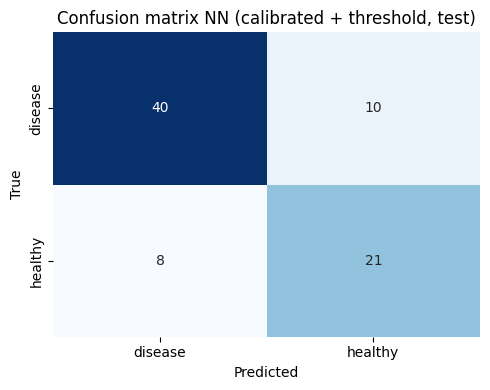

Report NN (calibrated + threshold):
               precision    recall  f1-score   support

     disease       0.83      0.80      0.82        50
     healthy       0.68      0.72      0.70        29

    accuracy                           0.77        79
   macro avg       0.76      0.76      0.76        79
weighted avg       0.78      0.77      0.77        79



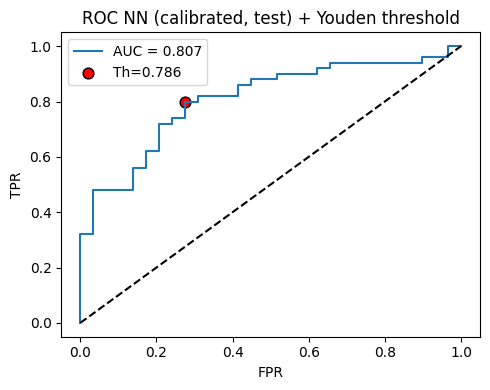

C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
C:\Users\Marc2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(est

In [7]:
input_dim = merged_df.shape[1]-1 # Taille de l'entrée du réseaux de neurones

num_classes = len(merged_df["diagnosis"].value_counts()) # Nombre de classes (2)

lr = 3e-3 # Learning rate 

nn_model = build_model(input_dim,num_classes,lr) # Création du réseaux de neurones

model = train_model(nn_model,merged_df,"diagnosis",verbose=True) # Entrainement du réseaux de neurones

model_cm.append(model["cm_final"]) # Affectation de la matrice de confusion dans la liste
        
# Affectation de la ligne dans le dataframe
report_df.loc[len(report_df)] = ["nn",
                                model["accuracy"],
                                model["precision"],
                                model["recall"], 
                                model["f1-score"], 
                                model["auc_calibrated"],
                                model["best_threshold"],
                                model["fold_scores"]]

 - Analyse

    - Matrice de confusion :

        - Pour la classe `disease`, les scores de `précision` et de `rappel` sont supérieur à $80$% , montrant donc que le modèle fait de bonnes prédictions pour la classe `disease` et se trompe rarement. Le F1-score atteste de cela avec une valeur de $82%$.

        - Pour la classe `healthy`, les scores sont un peu moins satisfaisant avec une précision de $68$% montrant donc que le modèle produit beaucoup de faux positifs et un rappel de $72$% étant synonyme de grand nombre de faux négatifs.

    - F1-score : 

### Conclusion

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=97fdffc1-05e0-4036-8d4f-2c2229b70573' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>